# Table of Contents
* [1. Importing the necessary libraries](#imports)
- [2. Reading the datasets](#reading)
- [3. Basic EDA](#eda)
- [4. Text data processing](#processing)
- [5. Transforming tokens to vectors](#vectorization)
- [6. Buiding a Text Classification model](#model)

# <a name="imports"></a>1. Importing the necessary libraries

In [1]:
import numpy as np
import pandas as pd

# text processing libraries
import re
import string
import nltk
from nltk.corpus import stopwords

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

# sklearn
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV,StratifiedKFold,RandomizedSearchCV

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# File system manangement
import os

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# <a name="reading"></a> 2. Reading the datasets

In [2]:
# List files available
print(os.listdir("../input/"))

['nlp-getting-started']


In [3]:
# Training data
train = pd.read_csv('../input/nlp-getting-started/train.csv')
print('Training data shape: ', train.shape)
train.head()

Training data shape:  (7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


학습 데이터는 7613개의 sample과 예측하고자 하는 `target`을 포함한 5개의 feature로 이루어져 있다.

In [4]:
# Testing data 
test = pd.read_csv('../input/nlp-getting-started/test.csv')
print('Testing data shape: ', test.shape)
test.head()

Testing data shape:  (3263, 4)


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


테스트 데이터에는 `target` 열이 없는 것을 확인할 수 있다.

# <a name="eda"></a> 3. Basic EDA

## Missing values

In [5]:
# Missing values in training set
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

각 열은 다음과 같다:

- `text`: 트윗의 내용
- `keyword`: 트윗으로부터 추출한 키워드
- `location`: 트윗이 작성된 위치

In [6]:
# Missing values in test set
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

학습 데이터, 테스트 데이터 모두에서 `location` 열에 결측치가 많은 것을 확인할 수 있다.

## Exploring the Target Column

* **Target 열의 분포**  
주어진 트윗이 실제로 재난(disaster)과 관련된 것인지 예측하고자 한다.

  - 재난과 관련된 경우: `1`
  - 관련되지 않은 경우: `0`

In [7]:
train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

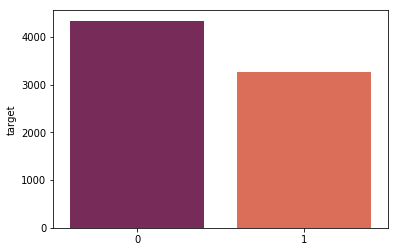

In [8]:
sns.barplot(train['target'].value_counts().index,train['target'].value_counts(),palette='rocket')

* **Target 열에 관해 알아보기**  
재난 관련 트윗과 그렇지 않은 트윗을 살펴보자.

In [9]:
# A disaster tweet
disaster_tweets = train[train['target']==1]['text']
disaster_tweets.values[1]

'Forest fire near La Ronge Sask. Canada'

In [10]:
# not a disaster tweet
non_disaster_tweets = train[train['target']==0]['text']
non_disaster_tweets.values[1]

'I love fruits'

## Exploring the 'keyword' column
`keyword` 열은 트윗의 키워드를 나타낸다. 학습 데이터 최상단 20개의 키워드를 살펴보고자 한다.

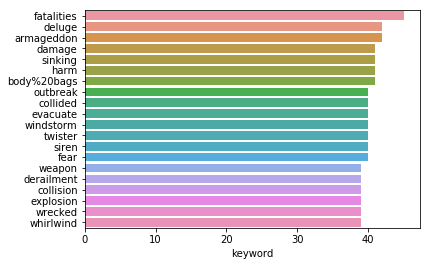

In [11]:
sns.barplot(y=train['keyword'].value_counts()[:20].index,
            x=train['keyword'].value_counts()[:20],
            orient='h')

'disaster' 단어가 데이터셋 내에서 얼마나 자주 등장하는지 살펴보고, 이것이 트윗을 분류하는 데 도움이 되는지 알아보자.

In [12]:
train.loc[train['text'].str.contains('disaster', na=False, case=False)].target.value_counts()

1    102
0     40
Name: target, dtype: int64

## Exploring the 'location' column
데이터셋 최상단 20개의 `location`을 확인해 보자. 중복되는 `location`을 다음과 같이 통합시키는 작업을 진행한다.

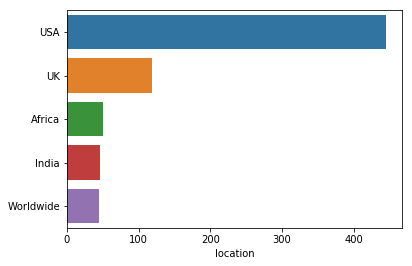

In [13]:
# Replacing the ambigious locations name with Standard names
train['location'].replace({'United States':'USA',
                           'New York':'USA',
                            "London":'UK',
                            "Los Angeles, CA":'USA',
                            "Washington, D.C.":'USA',
                            "California":'USA',
                             "Chicago, IL":'USA',
                             "Chicago":'USA',
                            "New York, NY":'USA',
                            "California, USA":'USA',
                            "FLorida":'USA',
                            "Nigeria":'Africa',
                            "Kenya":'Africa',
                            "Everywhere":'Worldwide',
                            "San Francisco":'USA',
                            "Florida":'USA',
                            "United Kingdom":'UK',
                            "Los Angeles":'USA',
                            "Toronto":'Canada',
                            "San Francisco, CA":'USA',
                            "NYC":'USA',
                            "Seattle":'USA',
                            "Earth":'Worldwide',
                            "Ireland":'UK',
                            "London, England":'UK',
                            "New York City":'USA',
                            "Texas":'USA',
                            "London, UK":'UK',
                            "Atlanta, GA":'USA',
                            "Mumbai":"India"}, inplace=True)

sns.barplot(y=train['location'].value_counts()[:5].index,x=train['location'].value_counts()[:5],
            orient='h')

> # <a name="processing"></a> 4. Text Data Preprocessing

## 1. Data Cleaning

NLP 프로젝트를 시작하기 전, 데이터를 형태를 일관되게 맞춰 주는 과정이 필요하다. 이를 데이터 전처리(Pre-processing)라고 하며, 다음과 같은 과정이 포함된다:

* 모든 텍스트를 **lower case** 또는 **uppercase**로 통일하여, 알고리즘이 같은 단어를 다르게 인식하지 않도록 한다.
* **Removing Noise**: 표준 숫자나 글자가 아닌 모든 것―구두점, 숫자 값, 무의미한 텍스트 등을 제거한다.
* **Tokenization**: 문자열로 되어 있는 텍스트 데이터를 token(i.e. 단어, 문장, 단락)들의 리스트로 만드는 작업을 뜻한다.
* **Stopword Removal**: 사용자가 요구하는 문서와 맞지 않는 단어를 vocabulary에서 완전히 제외시키는 작업을 뜻한다.

### tokenization 이후 다음과 같은 data cleaning이 이루어질 수 있다:

* **Stemming**: 어미만 변화한 형태의 같은 단어가 여러 번 등장했을 경우 어간만 남기고 모두 제거하는 작업을 뜻한다.
  * i.e. “Stems”, “Stemming”, “Stemmed”, ”Stemtization” 등의 단어가 있을 때, stemming을 진행하면 “stem”만이 남게 된다.
* **Lemmatization**: stemming과 비슷한데, 어간이 아닌 표제어(기본 사전형 단어)만을 남긴다는 점에서 차이가 있다. 예를 들어 “running”과 “ran”의 표제어는 “run”이며, “better”과 “good”의 표제어는 “good”이다.
* Parts of speech tagging
* Bi-grams 혹은 tri-grams 생성

이러한 과정이 모두 필수적인 것은 아니다. 해결하고자 하는 문제에 맞는 작업만을 취사선택하여 성능을 높일 수 있다.

In [14]:
# A quick glance over the existing data
train['text'][:5]

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: text, dtype: object

In [15]:
# Applying a first round of text cleaning techniques

def clean_text(text):
    '''
    Make text lowercase, remove text in square brackets, remove links,
    remove punctuation and remove words containing numbers.
    '''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

# Applying the cleaning function to both test and training datasets
train['text'] = train['text'].apply(lambda x: clean_text(x))
test['text'] = test['text'].apply(lambda x: clean_text(x))

# Let's take a look at the updated text
train['text'].head()

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3     people receive wildfires evacuation orders in...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

전처리를 진행한 텍스트 데이터로 wordcloud를 만들어, 가장 자주 등장한 단어를 알아보자.

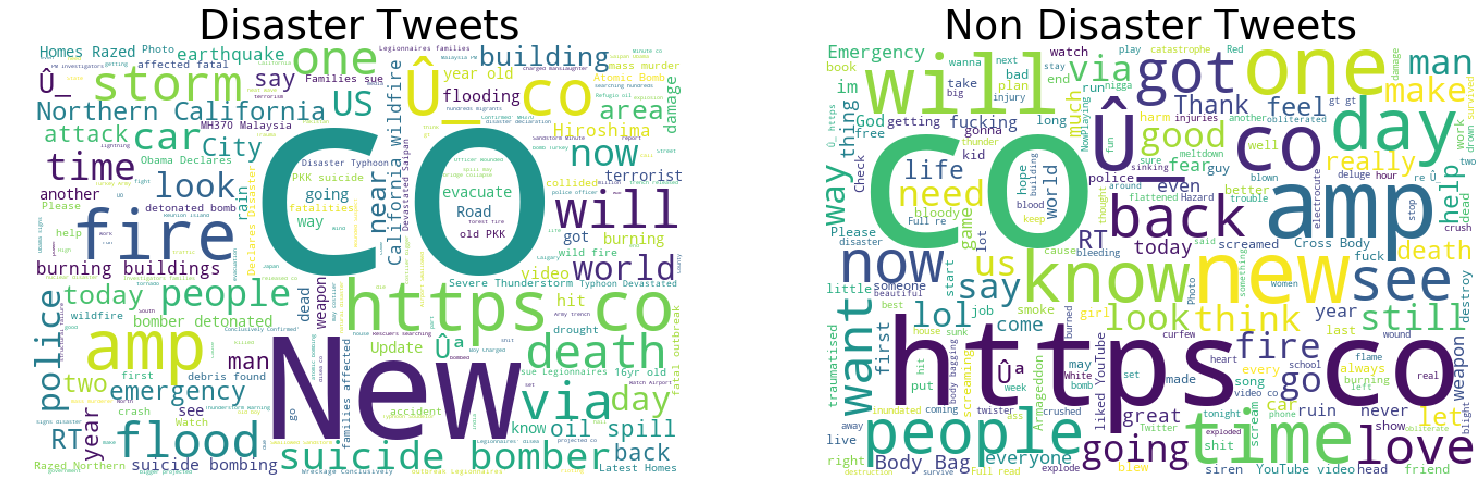

In [16]:
from wordcloud import WordCloud
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[26, 8])
wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(disaster_tweets))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Disaster Tweets',fontsize=40);

wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(non_disaster_tweets))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Non Disaster Tweets',fontsize=40);

## 2. Tokenization

Tokenization은 입력 시퀀스를 token으로 나누는 프로세스이다. 단어, 문장, 단락 등 다양한 형태의 token으로 나눌 수 있다.

In [17]:
text = "Are you coming , aren't you"
tokenizer1 = nltk.tokenize.WhitespaceTokenizer()
tokenizer2 = nltk.tokenize.TreebankWordTokenizer()
tokenizer3 = nltk.tokenize.WordPunctTokenizer()
tokenizer4 = nltk.tokenize.RegexpTokenizer(r'\w+')

print("Example Text: ",text)
print("--------------------------------------------------------------------------------")
print("Tokenization by whitespace:- ",tokenizer1.tokenize(text))
print("Tokenization by words using Treebank Word Tokenizer:- ",tokenizer2.tokenize(text))
print("Tokenization by punctuation:- ",tokenizer3.tokenize(text))
print("Tokenization by regular expression:- ",tokenizer4.tokenize(text))

Example Text:  Are you coming , aren't you
--------------------------------------------------------------------------------
Tokenization by whitespace:-  ['Are', 'you', 'coming', ',', "aren't", 'you']
Tokenization by words using Treebank Word Tokenizer:-  ['Are', 'you', 'coming', ',', 'are', "n't", 'you']
Tokenization by punctuation:-  ['Are', 'you', 'coming', ',', 'aren', "'", 't', 'you']
Tokenization by regular expression:-  ['Are', 'you', 'coming', 'aren', 't', 'you']


In [18]:
# Tokenizing the training and the test set
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
train['text'] = train['text'].apply(lambda x: tokenizer.tokenize(x))
test['text'] = test['text'].apply(lambda x: tokenizer.tokenize(x))
train['text'].head()

0    [our, deeds, are, the, reason, of, this, earth...
1        [forest, fire, near, la, ronge, sask, canada]
2    [all, residents, asked, to, shelter, in, place...
3    [people, receive, wildfires, evacuation, order...
4    [just, got, sent, this, photo, from, ruby, ala...
Name: text, dtype: object

## 3. Stopwords Removal

굉장히 자주 등장하지만 특별한 의미는 갖지 않는 **a, an, the, are**와 같은 단어를 제거하자.

In [19]:
def remove_stopwords(text):
    """
    Removing stopwords belonging to english language
    """
    words = [w for w in text if w not in stopwords.words('english')]
    return words

train['text'] = train['text'].apply(lambda x : remove_stopwords(x))
test['text'] = test['text'].apply(lambda x : remove_stopwords(x))
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,"[deeds, reason, earthquake, may, allah, forgiv...",1
1,4,NaN,NaN,"[forest, fire, near, la, ronge, sask, canada]",1
2,5,NaN,NaN,"[residents, asked, shelter, place, notified, o...",1
3,6,NaN,NaN,"[people, receive, wildfires, evacuation, order...",1
4,7,NaN,NaN,"[got, sent, photo, ruby, alaska, smoke, wildfi...",1


## 4. Token normalization

Token normalisation은 서로 다른 token들을 기본 형태로 변환하는 것이다. 다음과 같은 작업을 통해 이루어진다:

- **Stemming**: 어미를 제거한 어간만을 남긴다. (e.g. cats-cat, wolves-wolv)
- **Lemmatization**: 단어를 표제어(기본 사전형 단어)의 형태로 변환시킨다.

In [20]:
# Stemming and Lemmatization examples
text = "feet cats wolves talked"

tokenizer = nltk.tokenize.TreebankWordTokenizer()
tokens = tokenizer.tokenize(text)

# Stemmer
stemmer = nltk.stem.PorterStemmer()
print("Stemming the sentence:", " ".join(stemmer.stem(token) for token in tokens))

# Lemmatizer
lemmatizer=nltk.stem.WordNetLemmatizer()
print("Lemmatizing the sentence:", " ".join(lemmatizer.lemmatize(token) for token in tokens))

Stemming the sentence: feet cat wolv talk
Lemmatizing the sentence: foot cat wolf talked


Stemming과 lemmatization이 필수적인 작업은 아니며, 오히려 성능을 낮출 수도 있음에 주의하자. 간혹 본래 형태가 필요한 경우가 있으므로 해결하고자 하는 문제에 따라 활용 여부를 판단해야 한다. 본 문제에서는 이러한 작업을 거치지 않는다.

In [21]:
# After preprocessing, the text format
def combine_text(list_of_text):
    """
    Takes a list of text and combines them into one large chunk of text.
    """
    combined_text = ' '.join(list_of_text)
    return combined_text

train['text'] = train['text'].apply(lambda x : combine_text(x))
test['text'] = test['text'].apply(lambda x : combine_text(x))
train['text']
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officer...,1
3,6,NaN,NaN,people receive wildfires evacuation orders cal...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1


### Getting it all together- A Text Preprocessing Function
다음 함수를 통해 현재까지의 모든 전처리를 수행할 수 있다.

In [22]:
# text preprocessing function
def text_preprocessing(text):
    """
    Cleaning and parsing the text.
    """
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    
    nopunc = clean_text(text)
    tokenized_text = tokenizer.tokenize(nopunc)
    remove_stopwords = [w for w in tokenized_text if w not in stopwords.words('english')]
    combined_text = ' '.join(remove_stopwords)
    
    return combined_text

# <a name="vectorization"></a>  5. Transforming tokens to a vector
기본적인 전처리 과정을 거친 후, 텍스트를 벡터(숫자 배열)로 나타내어야 한다. 다음과 같은 기법을 활용하여 수행할 수 있다:

## Bag of Words

Bag-of-words는 특정한 단어가 문서 내에 얼마나 등장했는지를 표현하며, 다음과 같은 정보를 포함한다:

- 단어 사전(A vocabulary of known words)
- 단어의 출현 빈도 측정값(A measure of the presence of known words)

scikit-learn 라이브러리 내의 `CountVectorizer`를 활용하여 출현 빈도를 측정할 수 있다. 각 행은 서로 다른 트윗을, 각 열은 서로 다른 단어를 나타낸다.


In [23]:
count_vectorizer = CountVectorizer()
train_vectors = count_vectorizer.fit_transform(train['text'])
test_vectors = count_vectorizer.transform(test["text"])

# Keeping only non-zero elements to preserve space
print(train_vectors[0].todense())

[[0 0 0 ... 0 0 0]]


### TF-IDF Features

Bag of Words 방식은 다음과 같은 문제가 있다.
- 출현 빈도가 높은 단어의 영향이 커진다.
  - 해당 단어가 포함하는 정보가 무의미함에도 중요하게 판단될 수 있다.
- 문서의 길이가 긴 경우에 더 높은 가중치를 부여할 수 있다.

각 단어가 전체 문서에서 얼마나 자주 등장했는지의 값을 활용하여 각 문서에 대한 빈도 값을 scaling해줄 수 있다. 예를 들어 특정 문서에서 “the”가 자주 등장했을 때, 다른 모든 문서에서도 자주 등장한 것이 확인되면 이 빈도 값을 무시할 수 있게 된다. 이러한 방식을 **Term Frequency-Inverse Document Frequency(TF-IDF)**라고 부른다.

**Term Frequency: 현재 문서에 대한 특정 단어의 출현 빈도**

```
TF = (단어 t가 현재 문서 내에서 출현한 횟수) / (현재 문서의 전체 단어 수)
```

**Inverse Document Frequency: 특정 단어가 전체 문서 내에서 얼마나 희소한지**

```
IDF = 1 + log(N/n)  
이때, N은 전체 문서의 수이며, n은 전체 문서 중 단어 t가 출현한 문서의 수이다.
```

In [24]:
tfidf = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))
train_tfidf = tfidf.fit_transform(train['text'])
test_tfidf = tfidf.transform(test["text"])

# <a name="model"></a> 6. Building a Text Classification model
이제 데이터를 분류 모델에 넣을 수 있게 되었다. 기본적인 분류 알고리즘을 활용하여 모델이 잘 동작하는지 확인해 보자.

## Logistic Regression Classifier

In [25]:
# Fitting a simple Logistic Regression on Counts
clf = LogisticRegression(C=1.0)
scores = model_selection.cross_val_score(clf, train_vectors, train["target"], cv=5, scoring="f1")
scores

array([0.59865255, 0.50301464, 0.57118787, 0.5669145 , 0.68888889])

In [26]:
clf.fit(train_vectors, train["target"])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [27]:
# Fitting a simple Logistic Regression on TF-IDF
clf_tfidf = LogisticRegression(C=1.0)
scores = model_selection.cross_val_score(clf_tfidf, train_tfidf, train["target"], cv=5, scoring="f1")
scores

array([0.57258065, 0.49626866, 0.54277829, 0.46618106, 0.64768683])

이 경우, `Countvectorizer`가 TF-IDF보다 좋은 성능을 보이는 듯하다.

## Naives Bayes Classifier
텍스트 데이터에 잘 작동하는 Naive Bayes 모델을 적용해 보자.

In [28]:
# Fitting a simple Naive Bayes on Counts
clf_NB = MultinomialNB()
scores = model_selection.cross_val_score(clf_NB, train_vectors, train["target"], cv=5, scoring="f1")
scores

array([0.63324979, 0.60688666, 0.68718683, 0.64341085, 0.72505092])

In [29]:
clf_NB.fit(train_vectors, train["target"])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [30]:
# Fitting a simple Naive Bayes on TF-IDF
clf_NB_TFIDF = MultinomialNB()
scores = model_selection.cross_val_score(clf_NB_TFIDF, train_tfidf, train["target"], cv=5, scoring="f1")
scores

array([0.57590597, 0.57067603, 0.61188811, 0.5962963 , 0.7393745 ])

로지스틱 회귀의 경우와는 다르게, Naive Bayes는 TF-IDF feature에 더 좋은 성능을 보이는 것을 확인할 수 있다.

In [31]:
clf_NB_TFIDF.fit(train_tfidf, train["target"])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

## XGBoost

In [32]:
import xgboost as xgb
clf_xgb = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8,
                            subsample=0.8, nthread=10, learning_rate=0.1)
scores = model_selection.cross_val_score(clf_xgb, train_vectors, train["target"], cv=5, scoring="f1")
scores

array([0.46775956, 0.384689  , 0.4330855 , 0.38900634, 0.53142857])

In [33]:
clf_xgb_TFIDF = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                                  subsample=0.8, nthread=10, learning_rate=0.1)
scores = model_selection.cross_val_score(clf_xgb_TFIDF, train_tfidf, train["target"], cv=5, scoring="f1")
scores

array([0.47533632, 0.32510288, 0.42830189, 0.40084388, 0.53014354])

## Making the submission

In [34]:
def submission(submission_file_path,model,test_vectors):
    sample_submission = pd.read_csv(submission_file_path)
    sample_submission["target"] = model.predict(test_vectors)
    sample_submission.to_csv("submission.csv", index=False)

In [35]:
submission_file_path = "../input/nlp-getting-started/sample_submission.csv"
test_vectors=test_tfidf
submission(submission_file_path, clf_NB_TFIDF, test_vectors)